In [1]:
## Compare reconstruction of streamfunction with pyqg

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import pyqg

/ext3/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
snap_index=5000

## Load in saved dataset
ds=xr.load_dataset("/scratch/cp3759/pyqg_data/sims/rollouts/rollout_BScat_252.nc")
p1=ds.p[snap_index][0]
p2=ds.p[snap_index][1]

q1=ds.q[snap_index][0]
q2=ds.q[snap_index][1]

q=np.stack((q1,q2))

In [3]:
## Initialise pyqg model
m=pyqg.QGModel()

INFO:  Logger initialized


In [50]:
def torch_invert(q,m,num_runs=1):
    q1=torch.tensor(q[0])
    q2=torch.tensor(q[1])
    
    q1_fft=torch.fft.rfftn(q1)
    q2_fft=torch.fft.rfftn(q2)
    
    
    
    ## Set up grid
    
    x,y = torch.meshgrid(
    torch.arange(0.5,m.nx,1.)/m.nx*m.L,
    torch.arange(0.5,m.ny,1.)/m.ny*m.W )

    # Notice: at xi=1 U=beta*rd^2 = c for xi>1 => U>c
    # wavenumber one (equals to dkx/dky)
    dk = 2.*math.pi/m.L
    dl = 2.*math.pi/m.W

    # wavenumber grids
    # set in kernel
    ll = dl*torch.cat((torch.arange(0.,m.nx/2),
        torch.arange(-m.nx/2,0.)))
    kk = dk*torch.arange(0.,m.nk)

    k, l = torch.meshgrid(kk, ll)
    ik = 1j*k
    il = 1j*l
    # physical grid spacing
    dx = m.L / m.nx
    dy = m.W / m.ny
    
    for aa in range(num_runs):
        ## Calculate determinants
        kappa2=(l**2+k**2).T
        dets=kappa2*(kappa2+m.F1+m.F2)

        dets[0,0]=1e-19

        ph1=(-(kappa2+m.F2)*q1_fft-m.F1*q2_fft)/dets
        ph2=(-m.F2*q1_fft-(kappa2+m.F1)*q2_fft)/dets

        ph1[0,0]=0
        ph2[0,0]=0

        psi_recons1=torch.fft.irfftn(ph1)
        psi_recons2=torch.fft.irfftn(ph2)
    
    return torch.stack((psi_recons1,psi_recons2))

In [51]:
import time

In [62]:
num_runs=int(5e4)

In [63]:
t0 = time.time()
psi_r=torch_invert(q,m,num_runs=num_runs)
print(f"Took {time.time() - t0:.1f} seconds.")

Took 12.8 seconds.


In [64]:
## Use pyqg model to get psi
m.q = q.astype(np.float64)
t0 = time.time()
for aa in range(num_runs):
    m._invert()
print(f"Took {time.time() - t0:.1f} seconds.")
pyqg_psi=(m.to_dataset().p).to_numpy()

Took 6.4 seconds.


In [44]:
pyqg_psi[0][0].shape

(64, 64)

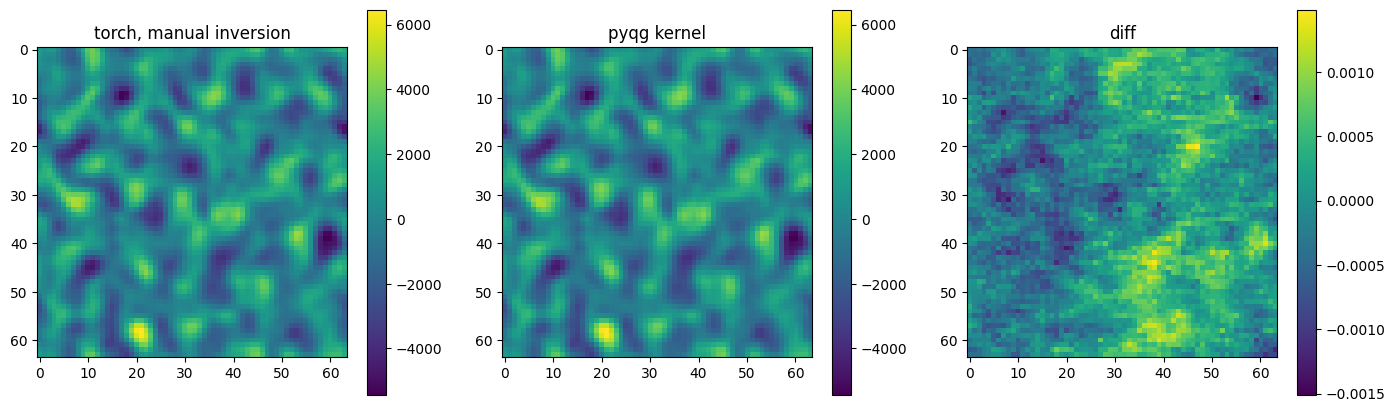

In [48]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))
im1=ax1.imshow(psi_r[0])
ax1.set_title("torch, manual inversion")
fig.colorbar(im1,ax=ax1,orientation='vertical')
im2=ax2.imshow(pyqg_psi[0][0])
ax2.set_title("pyqg kernel")
fig.colorbar(im2,ax=ax2,orientation='vertical')
ax3.set_title("diff")
im3=ax3.imshow(psi_r[0]-pyqg_psi[0][0])
fig.colorbar(im3,ax=ax3,orientation='vertical')

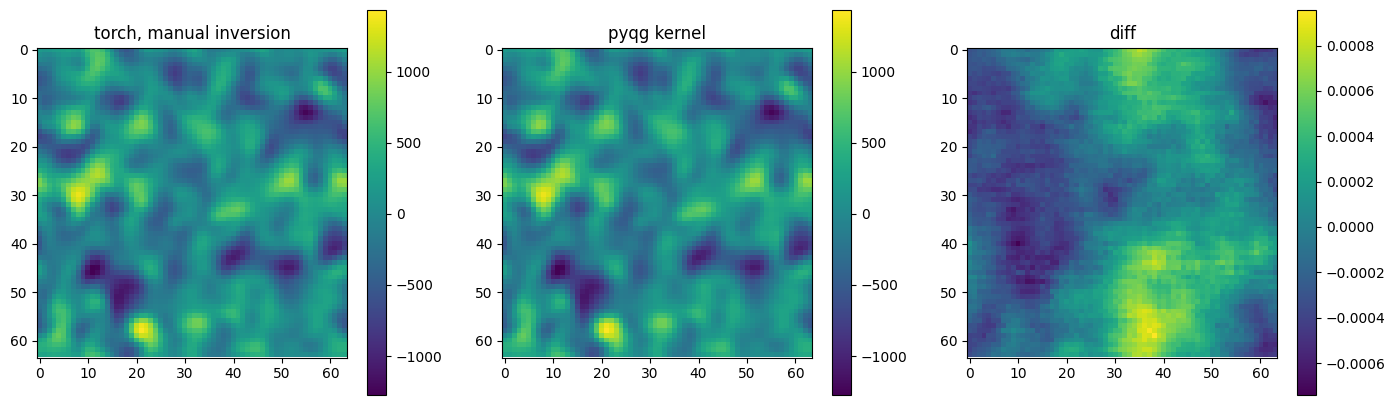

In [49]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,5))
im1=ax1.imshow(psi_r[1])
ax1.set_title("torch, manual inversion")
fig.colorbar(im1,ax=ax1,orientation='vertical')
im2=ax2.imshow(pyqg_psi[0][1])
ax2.set_title("pyqg kernel")
fig.colorbar(im2,ax=ax2,orientation='vertical')
im3=ax3.imshow(psi_r[1]-pyqg_psi[0][1])
ax3.set_title("diff")
fig.colorbar(im3,ax=ax3,orientation='vertical')

In [ ]:
torch.__version__

In [23]:
type(q)

numpy.ndarray

In [33]:
type(q[0,0,0])

numpy.float32

In [31]:
m.q[0,0]

array([1.08076988e-07, 5.89668441e-08, 8.10036938e-07, 7.16104401e-08,
       7.99091926e-07, 8.53529830e-07, 6.06051134e-07, 3.58902813e-07,
       5.73255642e-07, 6.74633595e-07, 3.81451933e-07, 7.75911205e-07,
       3.69367939e-07, 8.36880481e-07, 8.57656052e-07, 8.41444730e-07,
       6.61741492e-07, 7.50164932e-07, 4.31903765e-07, 5.49129916e-07,
       2.32075957e-07, 7.63803429e-07, 6.25774208e-07, 9.54166327e-07,
       1.27077853e-07, 4.55084937e-07, 9.04768821e-07, 1.76493595e-08,
       9.06855961e-07, 4.54851644e-07, 1.73194046e-07, 1.34505942e-07,
       4.44071051e-07, 3.32359894e-07, 3.49591114e-07, 6.28068046e-07,
       6.36122982e-07, 2.56314022e-07, 6.10483711e-07, 3.32906433e-07,
       9.53563025e-07, 3.59222791e-07, 1.04210462e-06, 6.26572033e-07,
       1.04228104e-06, 7.66991765e-07, 1.03004210e-06, 1.01947326e-06,
       8.07613787e-07, 8.50160592e-07, 1.74036347e-07, 2.33728522e-07,
       9.73116984e-07, 1.18774980e-07, 5.98379170e-07, 1.05408808e-06,
      